In [154]:
library(ANCOMBC)
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(microViz)
library("ggpubr")

In [155]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list
taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
# Convert taxonomy info to data frame with correct taxonomy labels
#taxa <- taxa_16S[-1,]
select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids
tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11, 12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [156]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA")) %>% 
mutate(
  Genotype = Genotype %>%
    str_replace_all("Kelsey-1", "Kelsey1") %>%
    str_replace_all("Cooper-9", "Cooper9")
)

meta$Genotype<-factor(meta$Genotype, 
                              levels=c("FM19", "FM6", "FM9", "U44",
                                       "FM14", "Elkhorn","K2",
                                      "Acerv2", "Kelsey1", "Cooper9"))


In [157]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [158]:
dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")

ps = subset_samples(ps, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps


ps=subset_taxa(ps, Phylum!="NA")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [159]:
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped

ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired


#only nutrient and placebo
ps_placebo_un =subset_samples(ps_Clipped, Diseased=="Placebo")
ps_placebo_un

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 106 samples ]
sample_data() Sample Data:       [ 106 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [160]:
ps_placebo_un_fill = filter_taxa(ps_placebo_un, function(x) sum(x > 5) > (0.05*length(x)), TRUE) %>% tax_fix()
ps_placebo_un_fill
                           
                                                                                    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 148 taxa and 106 samples ]
sample_data() Sample Data:       [ 106 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 148 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 148 tips and 126 internal nodes ]

In [161]:
sample_data(ps_placebo_un_fill) %>%
  group_by(Combo, Health) %>%
  summarize(Paired = n())

`summarise()` has grouped output by 'Combo'. You can override using the `.groups` argument.


Combo,Health,Paired
<chr>,<chr>,<int>
Ambient_Placebo,AH,42
NH4_Placebo,AH,59
NH4_Placebo,DL,5


In [19]:
colnames(meta)

[1] "sample_names"               "featurecounts"             
 [3] "Initial_sample_ID"          "Tag"                       
 [5] "start_date"                 "event_date"                
 [7] "Date_Collected"             "Date"                      
 [9] "TimePoint"                  "Replicate"                 
[11] "Genotype"                   "Nursery"                   
[13] "Nutrients"                  "Diseased"                  
[15] "Combo"                      "Tank_N"                    
[17] "Tank_D1"                    "Tank_D2"                   
[19] "Type"                       "Health"                    
[21] "Outcome"                    "Notes"                     
[23] "Severity"                   "Survivorship"              
[25] "Pairs"                      "Combo_health"              
[27] "Archive_box"                "Genotype.1"                
[29] "NH4_Susceptibility"         "Disease_Susceptibility"    
[31] "NH4_Disease_Susceptibility" "Expected"                  
[33] "Surv_disease"               "Surv_nutrients"            
[35] "surv"                       "std.err"                   
[37] "barcode_label"              "barcode_seq"               
[39] "ID"                         "Sequencing_Round"          
[41] "Plate_Name"                 "Plate_Barcode"             
[43] "Well_Position"              "Sequence_Name"             
[45] "Illumina5_Adapter"          "Forward_Primer_Pad"        
[47] "Golay_Barcode"              "X515FB_Forward_Primer"     
[49] "Primer_For_PCR"             "X"                         
[51] "estimate"                   "error"                     
[53] "lower"                      "upper"                     
[55] "name"                       "model"                     
[57] "Simpson"                    "Shannon"

In [162]:
set.seed(123)
output = ancombc2(data = ps_placebo_un_fill , tax_level = "ASVs",
                  fix_formula = "Combo", 
                  #rand_formula = "(1| Genotype)",
                  p_adj_method = "holm",  pairwise = TRUE,
                  group = "Combo",struc_zero = TRUE, alpha = 0.001,
                  dunnet = TRUE,
                  n_cl=4, prv_cut = 0, lib_cut = 1000
                  #lme_control = lme4::lmerControl()
                 )
        

Checking the input data type ...

The input data is of type: phyloseq

PASS

Checking the sample metadata ...

The specified variables in the formula: Combo

The available variables in the sample metadata: sample_names, featurecounts, Initial_sample_ID, Tag, start_date, event_date, Date_Collected, Date, TimePoint, Replicate, Genotype, Nursery, Nutrients, Diseased, Combo, Tank_N, Tank_D1, Tank_D2, Type, Health, Outcome, Notes, Severity, Survivorship, Pairs, Combo_health, Archive_box, Genotype.1, NH4_Susceptibility, Disease_Susceptibility, NH4_Disease_Susceptibility, Expected, Surv_disease, Surv_nutrients, surv, std.err, barcode_label, barcode_seq, ID, Sequencing_Round, Plate_Name, Plate_Barcode, Well_Position, Sequence_Name, Illumina5_Adapter, Forward_Primer_Pad, Golay_Barcode, X515FB_Forward_Primer, Primer_For_PCR, X, estimate, error, lower, upper, name, model, Simpson, Shannon

PASS

Checking other arguments ...

The number of groups of interest is: 2

Warning message:
“The group vari

In [163]:
res=output$res
head(res)

dim(res)

taxa_df = tax_table(ps_placebo_un_fill) %>% as.data.frame() %>% rownames_to_column("taxon")
head(taxa_df)

df_fig = res %>% left_join(taxa_df, by = "taxon")
dim(df_fig)
head(df_fig)

,taxon,lfc_(Intercept),lfc_ComboNH4_Placebo,se_(Intercept),se_ComboNH4_Placebo,W_(Intercept),W_ComboNH4_Placebo,p_(Intercept),p_ComboNH4_Placebo,q_(Intercept),q_ComboNH4_Placebo,diff_(Intercept),diff_ComboNH4_Placebo,passed_ss_(Intercept),passed_ss_ComboNH4_Placebo
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
1,cc47dbf08e19583b226ca7aef0fdfe88,-0.0004218133,-0.1109222,5.453390e-06,0.1286751,-77.348822,-0.8620326,3.143684e-10,0.4217805114,3.143684e-08,1.00000000,TRUE,FALSE,FALSE,TRUE
2,823c79a88cd4499479ebccd160c1d38b,0.2336375681,-0.4370232,8.520961e-03,0.1244951,27.419157,-3.5103645,1.207435e-06,0.0170940084,9.417996e-05,1.00000000,TRUE,FALSE,FALSE,TRUE
3,7dfdf546ed4b1ca29ad5fbc0fc732338,0.1342323100,-0.1940662,5.453390e-06,0.1255630,24614.472375,-1.5455683,1.634516e-17,0.1971026141,1.977764e-15,1.00000000,TRUE,FALSE,FALSE,TRUE
4,58d90c539c2da8cf55e6e222e58b6bc6,-0.2278196086,0.2714980,3.383044e-02,0.1319916,-6.734161,2.0569347,1.094935e-03,0.0948022895,4.051259e-02,1.00000000,FALSE,FALSE,TRUE,TRUE
5,544e3f697c0460869c81cc5c7e774c6a,0.9002518223,-1.1235974,5.453390e-06,0.1276518,165081.146354,-8.8020455,1.548162e-25,0.0003141427,2.043574e-23,0.04052441,TRUE,FALSE,FALSE,FALSE
6,94580582244d0d8eedb558e2a90c33fa,-0.4492418025,0.3670031,1.021726e-02,0.1270800,-43.968926,2.8879701,9.266075e-09,0.0277670679,8.432128e-07,1.00000000,TRUE,FALSE,FALSE,TRUE


[1] 138  15

,taxon,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cc47dbf08e19583b226ca7aef0fdfe88,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_8105
2,823c79a88cd4499479ebccd160c1d38b,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5181
3,2549b8aa248e7607235d17caa2578426,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_1483
4,a14b7162edeb7a30ddb2a46656539857,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_6427
5,7dfdf546ed4b1ca29ad5fbc0fc732338,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5032
6,7355549fa5ae6af5a0a0419c7aa91137,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_4620


[1] 138  23

,taxon,lfc_(Intercept),lfc_ComboNH4_Placebo,se_(Intercept),se_ComboNH4_Placebo,W_(Intercept),W_ComboNH4_Placebo,p_(Intercept),p_ComboNH4_Placebo,q_(Intercept),⋯,passed_ss_(Intercept),passed_ss_ComboNH4_Placebo,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cc47dbf08e19583b226ca7aef0fdfe88,-0.0004218133,-0.1109222,5.453390e-06,0.1286751,-77.348822,-0.8620326,3.143684e-10,0.4217805114,3.143684e-08,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_8105
2,823c79a88cd4499479ebccd160c1d38b,0.2336375681,-0.4370232,8.520961e-03,0.1244951,27.419157,-3.5103645,1.207435e-06,0.0170940084,9.417996e-05,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5181
3,7dfdf546ed4b1ca29ad5fbc0fc732338,0.1342323100,-0.1940662,5.453390e-06,0.1255630,24614.472375,-1.5455683,1.634516e-17,0.1971026141,1.977764e-15,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5032
4,58d90c539c2da8cf55e6e222e58b6bc6,-0.2278196086,0.2714980,3.383044e-02,0.1319916,-6.734161,2.0569347,1.094935e-03,0.0948022895,4.051259e-02,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_3574
5,544e3f697c0460869c81cc5c7e774c6a,0.9002518223,-1.1235974,5.453390e-06,0.1276518,165081.146354,-8.8020455,1.548162e-25,0.0003141427,2.043574e-23,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_3397
6,94580582244d0d8eedb558e2a90c33fa,-0.4492418025,0.3670031,1.021726e-02,0.1270800,-43.968926,2.8879701,9.266075e-09,0.0277670679,8.432128e-07,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5921


In [164]:
taxa_df = tax_table(ps_placebo_un_fill) %>% as.data.frame() %>% rownames_to_column("taxon")
head(taxa_df)

,taxon,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,cc47dbf08e19583b226ca7aef0fdfe88,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_8105
2,823c79a88cd4499479ebccd160c1d38b,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5181
3,2549b8aa248e7607235d17caa2578426,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_1483
4,a14b7162edeb7a30ddb2a46656539857,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_6427
5,7dfdf546ed4b1ca29ad5fbc0fc732338,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5032
6,7355549fa5ae6af5a0a0419c7aa91137,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_4620


In [180]:
df_fig = res %>% left_join(taxa_df, by = "taxon") %>%
filter(lfc_ComboNH4_Placebo < -0.5 | lfc_ComboNH4_Placebo > 0.5) %>%
filter(passed_ss_ComboNH4_Placebo == "TRUE") 
dim(df_fig)
head(df_fig)

[1] 21 23

,taxon,lfc_(Intercept),lfc_ComboNH4_Placebo,se_(Intercept),se_ComboNH4_Placebo,W_(Intercept),W_ComboNH4_Placebo,p_(Intercept),p_ComboNH4_Placebo,q_(Intercept),⋯,passed_ss_(Intercept),passed_ss_ComboNH4_Placebo,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,46770fda10806444cca198c487dd1c64,-0.9125952,0.8486920,5.453390e-06,0.1272966,-1.673446e+05,6.667044,7.650762e-21,0.002629874,9.563453e-19,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,g__Shimia Genus,ASV_2850
2,73a7fd37f899efcd218459560acd8e38,0.4512070,-0.5332834,1.474351e-02,0.1247734,3.060377e+01,-4.274015,3.252444e-11,0.001626665,3.545164e-09,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_4635
3,7ec46cc62d30097b3d75a74935cb197b,-0.2016441,0.5076487,2.309047e-02,0.1270760,-8.732784e+00,3.994842,3.261231e-04,0.010376424,1.369717e-02,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5066
4,380e94062cd8f44ea50814193ad56225,0.3590138,-0.6064550,3.715514e-02,0.1342715,9.662561e+00,-4.516632,2.175299e-06,0.001114120,1.653227e-04,⋯,FALSE,TRUE,d__Bacteria,p__Actinobacteriota,c__Actinobacteria,o__Corynebacteriales,f__Mycobacteriaceae,g__Mycobacterium,g__Mycobacterium Genus,ASV_2240
5,27dbb0e4b4920b6681df8a9e99c241b5,-0.8909664,0.5892811,3.326739e-02,0.1322115,-2.678197e+01,4.457108,4.065692e-09,0.002119189,3.781094e-07,⋯,FALSE,TRUE,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,g__Spirochaeta_2 Genus,ASV_1594
6,caa981194050ca47e53f144a79dd1bc6,-0.7734807,0.5394527,3.392591e-02,0.1319687,-2.279911e+01,4.087732,1.305483e-10,0.001796436,1.357702e-08,⋯,FALSE,TRUE,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,g__Spirochaeta_2 Genus,ASV_8044


In [182]:
write_csv(df_fig, "/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/Ancom_nutrients.csv")

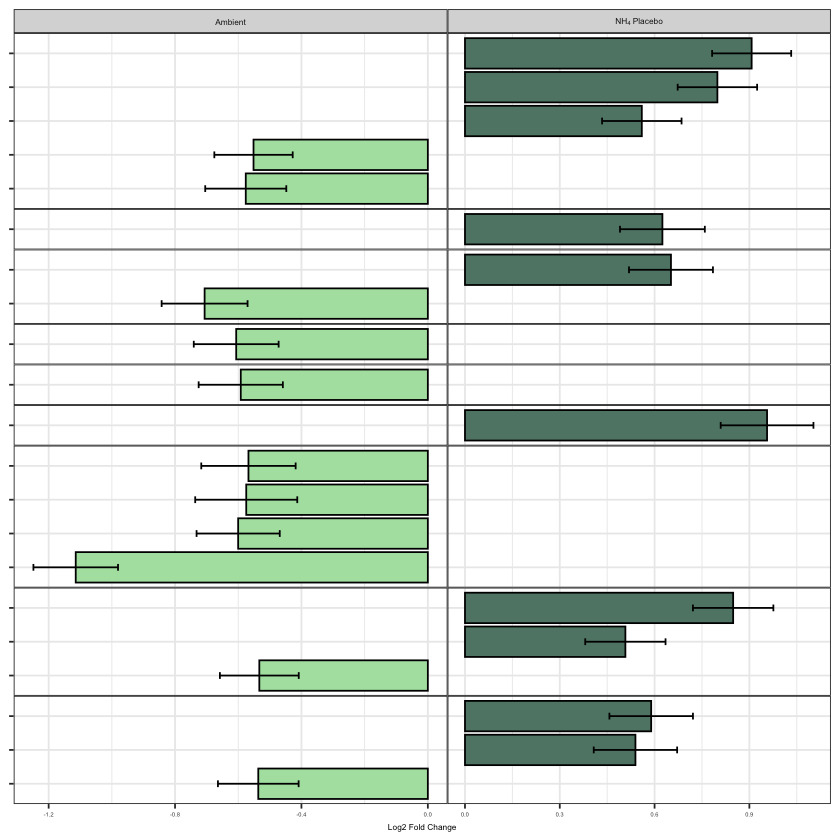

In [175]:


combo_labs <- as_labeller(c("NH4" = "NH[4]~Placebo",
                          "Ambient" = "Ambient"), default = label_parsed)


F1 <- df_fig %>%
 filter(passed_ss_ComboNH4_Placebo == "TRUE") %>%
  mutate_if(is.character, str_replace_all, pattern = "o__", replacement = "") %>%
 
  mutate(
    direction = ifelse(lfc_ComboNH4_Placebo > 0, "NH4", "Ambient"),
    direction = factor(direction, levels = c("Ambient", "NH4"))
  ) %>%
  ggplot(aes(x = reorder(ASVs, lfc_ComboNH4_Placebo), y = lfc_ComboNH4_Placebo, fill = direction)) +
  geom_bar(stat = "identity", color = "black") +
  geom_errorbar(aes(ymin = lfc_ComboNH4_Placebo - se_ComboNH4_Placebo, 
                    ymax = lfc_ComboNH4_Placebo + se_ComboNH4_Placebo), width = 0.2) +
  coord_flip() +
  labs(
    x = "ASVs",
    y = "Log2 Fold Change",
    fill = "Direction"
  ) +
  scale_fill_manual(values = c("NH4" = "#5F8575", "Ambient" = "#AFE1AF")) +
  facet_grid(Order ~
             direction, 
             space = "free", scales = "free",
             switch = "y",  labeller = labeller(direction = combo_labs)) +
  theme_bw() +
  theme(
    axis.title.x = element_text(size = 5),
    axis.title.y = element_blank(),
    axis.text.x = element_text(size = 3.5),
    axis.text.y = element_blank(),
    strip.text.x = element_text(size = 5),
    strip.text.y = element_blank(),
    #  strip.text.y = element_text(size=5),
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 5),
    legend.position = "none",
    panel.spacing.x = unit(0.0, "lines"),
    panel.spacing.y = unit(0.0, "lines")
  ) 
#theme(axis.text.x = element_text(angle = 60, hjust = 1)) 
F1

In [170]:
psr_fill_melt = ps_placebo_un_fill  %>%  
  #tax_glom("Genus") %>% 
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()   


taxa_fil= df_fig %>% column_to_rownames("taxon")%>%
as.matrix


ps_DLPL=phyloseq(otu_table(ASVs, taxa_are_rows=TRUE), 
               sample_data(meta),
              tax_table(taxa_fil))
ps_DLPL=subset_samples(ps_DLPL, !ID %in% dups & Genotype!="U41")
ps_DLPL



ps_ancom_APa = subset_samples(ps_DLPL,
                      Type=="Clipped" &  Diseased=="Placebo" )
#ps_ancom_APa = subset_samples(ps_ancom_APa, Pairs=="paired")
#ps_ancom_APa

psr_fill_melt = ps_ancom_APa  %>%  
  #tax_glom("Genus") %>% 
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()  


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 42 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 42 taxa by 22 taxonomic ranks ]

In [171]:
head(psr_fill_melt)

,OTU,Sample,Abundance,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,Date_Collected,⋯,passed_ss_.Intercept.,passed_ss_ComboNH4_Placebo,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
442,16b99e2f8fc40ee86e4938012fff53b8,N255-A198,1,N255-A198,29958,255,A198,2020-08-19,2020-11-10,10-Nov-20,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Alteromonadaceae,g__uncultured,s__uncultured_marine,ASV_927
1257,380e94062cd8f44ea50814193ad56225,N9-A048,1,N9-A048,45982,9,A048,2020-08-19,2020-10-25,25-Oct-20,⋯,FALSE,TRUE,d__Bacteria,p__Actinobacteriota,c__Actinobacteria,o__Corynebacteriales,f__Mycobacteriaceae,g__Mycobacterium,g__Mycobacterium Genus,ASV_2240
1404,415597a17116d25b78e4d63914b5a92a,N242-293,1,N242-293,27836,242,293,2020-08-19,2020-11-10,10-Nov-20,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Alteromonadaceae,g__uncultured,s__uncultured_marine,ASV_2637
1450,415597a17116d25b78e4d63914b5a92a,N201-A069,1,N201-A069,24008,201,A069,2020-08-19,2020-11-10,10-Nov-20,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Alteromonadaceae,g__uncultured,s__uncultured_marine,ASV_2637
1913,66760a62cc03e185f372c9797b2b48a9,N261-266,1,N261-266,36235,261,266,2020-08-19,2020-11-10,10-Nov-20,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Endozoicomonadaceae,g__Endozoicomonas,s__Acropora_cervicornis,ASV_4109
1984,66760a62cc03e185f372c9797b2b48a9,N126-A154,1,N126-A154,32407,126,A154,2020-08-19,2020-11-06,6-Nov-20,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Endozoicomonadaceae,g__Endozoicomonas,s__Acropora_cervicornis,ASV_4109



Ambient     NH4 
    121      76 


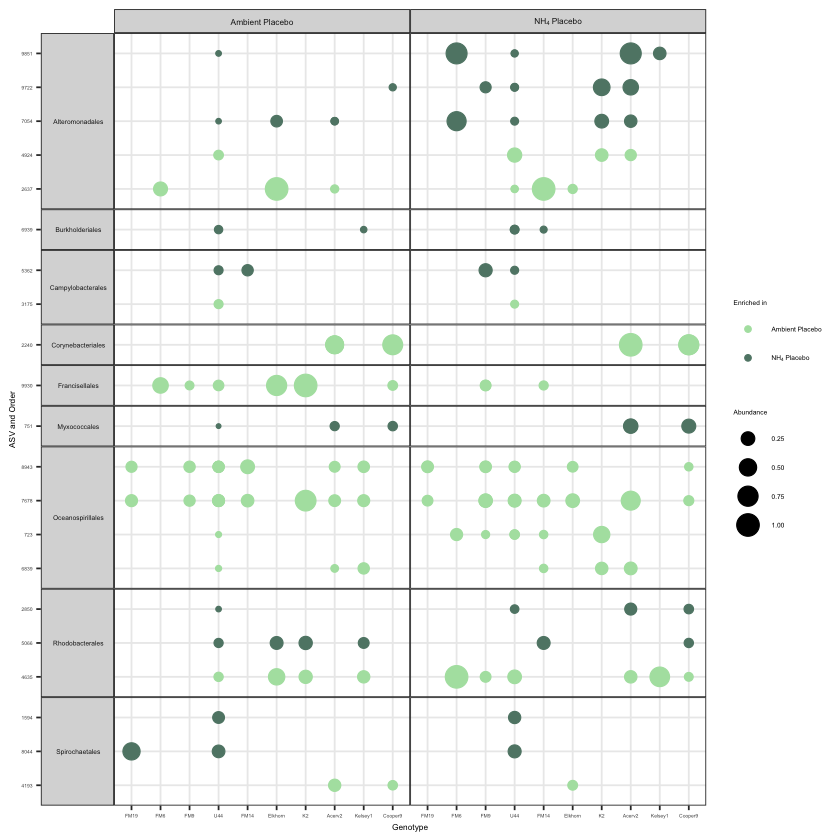

In [177]:

library(stringr)
psr_fill_melt <- psr_fill_melt %>%
  mutate(Combo = factor(Combo, levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen")))
# Define labellers
combo_labs <- as_labeller(c(
  "Ambient_Placebo" = "Ambient~Placebo",
  "Ambient_Pathogen" = "Ambient+Disease",
  "NH4_Placebo" = "NH[4]~Placebo",
  "NH4_Pathogen" = "NH[4]+Disease"
), default = label_parsed)


lab1 <- c(expression(Ambient~Placebo),
          
          expression(NH[4]~Placebo))
# Plot
F2 <- psr_fill_melt %>%
  as.data.frame() %>%
  mutate(
    Abundance = as.numeric(as.character(Abundance)),
    lfc_ComboNH4_Placebo = as.numeric(str_trim(as.character(lfc_ComboNH4_Placebo)))
  ) %>%
  filter(
    passed_ss_ComboNH4_Placebo == "TRUE",
    Abundance > 0,
    !is.na(Severity)
  ) %>%
  mutate(
    Enriched  = ifelse(lfc_ComboNH4_Placebo > 0, "NH4", "Ambient")
  ) %>%
  { print(table(.$Enriched)); . } %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "o__", ""))) %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "ASV_", ""))) %>%

  ggplot(aes(x = Genotype, y = reorder(ASVs, lfc_ComboNH4_Placebo))) +
  geom_point(aes(size = Abundance, color = Enriched)) +
  scale_color_manual("Enriched in", values = c("#AFE1AF", "#5F8575"),labels=lab1) +
  facet_grid(
    Order ~ Combo,
    space = "free",
    scales = "free",
    switch = "y",
      labeller = labeller(Combo = combo_labs
    )
  ) +
  theme_bw() +
  theme(
    axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 5),
    axis.text.x = element_text(size = 3),
    axis.text.y = element_text(size = 3),
    strip.text.y = element_text(size = 4),
    strip.text.y.left = element_text(angle = 0),
    strip.text.x = element_text(size = 5),
    legend.text = element_text(size = 4),
    legend.title = element_text(size = 4),
    panel.spacing.x = unit(0.0, "lines"),
    panel.spacing.y = unit(0.0, "lines")
  ) +
#theme(axis.text.x = element_text(angle = 20, hjust = 1)) +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
  ylab("ASV and Order")
F2

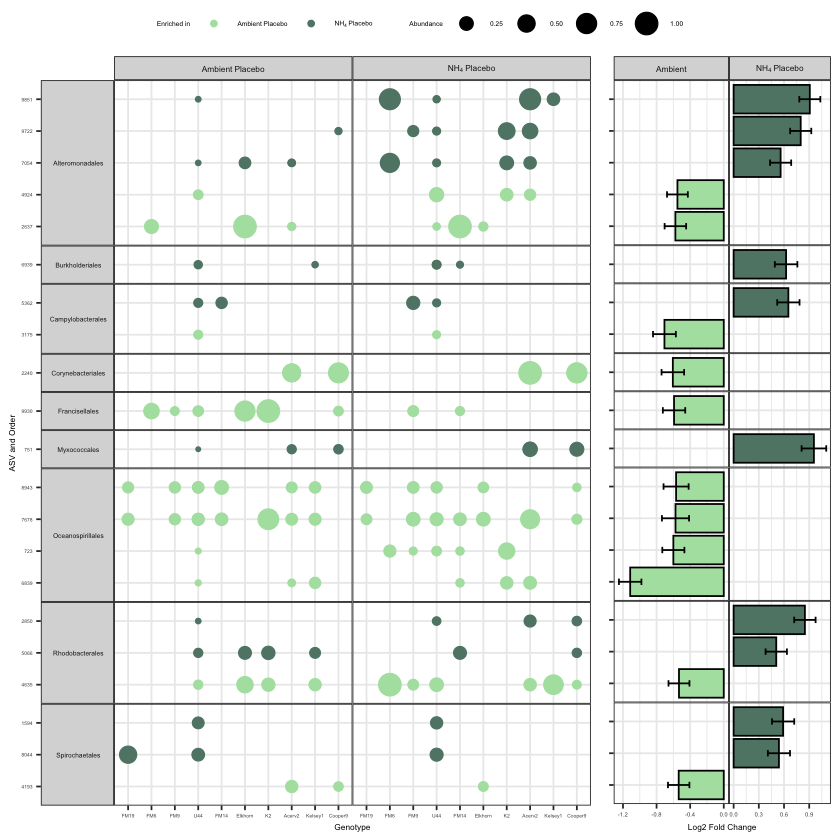

In [178]:
 ggpubr::ggarrange(F2, F1, common.legend = TRUE, legend = "top",
                   widths=c(2,0.8))
ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/new_ANCOM_nutrients.jpg", 
      width = 6, height = 4, units = "in", dpi=300)

In [3]:
sessionInfo()

R version 4.5.0 (2025-04-11)
Platform: aarch64-apple-darwin20
Running under: macOS Sequoia 15.4.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.6.0      microViz_0.12.7   lubridate_1.9.4   forcats_1.0.0    
 [5] stringr_1.5.1     dplyr_1.1.4       purrr_1.0.4       readr_2.1.5      
 [9] tidyverse_2.0.0   microbiome_1.30.0 phyloseq_1.52.0   ggplot2_3.5.2    
[13] tibble_3.2.1      tidyr_1.3.1       qiime2R_0.99.6    ANCOMBC_2.10.0   

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3      rstudioapi_0.17.1       jsonlite_2.0